In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

# Cointegration and Correlation Analysis

In [3]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    # return (stock_data['Close'].pct_change().dropna() + 1).cumprod() - 1
    return stock_data['Close']

# Define the fixed stock and a list of different stocks to pair with
fixed_stock = '1876.HK'
stocks_to_pair = [
    '0291.HK', 
    '0168.HK',  
    # '9633.HK', 
    # '2460.HK'
]  # Add more stocks as needed
name_mapping = {
    '1876.HK': 'Budweiser APAC',
    '0291.HK': 'CR Beer',
    '0168.HK': 'Qing Dao Beer',
    # '9633.HK': 'Nong Fu Shan Quan',
    # '2460.HK': 'CR Drinks'
}

[*********************100%***********************]  3 of 3 completed


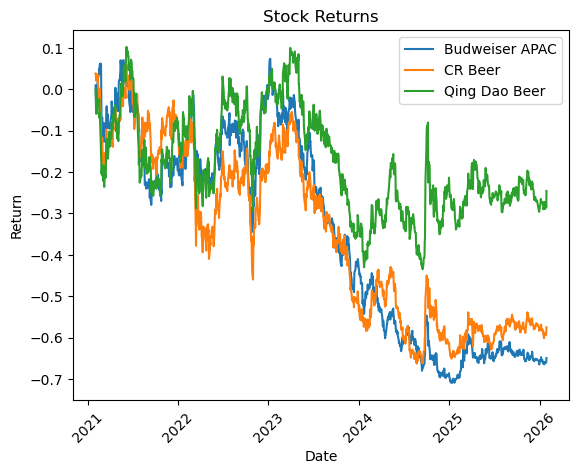

In [4]:
# Fetch historical stock price data and perform analysis for each pair
results = []
start_date = "2021-02-01"
end_date = "2026-01-30"
price_data = fetch_stock_data([fixed_stock]+stocks_to_pair, start_date, end_date)
price_data = price_data.fillna(method='ffill').dropna()
returns = (price_data.pct_change().dropna() + 1).cumprod() - 1
fixed_stock_data = returns[fixed_stock]
plt.plot(fixed_stock_data, label=name_mapping[fixed_stock])
for stock in stocks_to_pair:
    paired_stock_data = returns[stock]

    # cointegration_test = coint(fixed_stock_data, paired_stock_data)
    # cointegration_p_value = cointegration_test[1]

    # Step 1: Regression of paired stock on fixed stock
    X = sm.add_constant(fixed_stock_data)
    model = sm.OLS(paired_stock_data, X).fit()
    residuals = model.resid

    # Step 2: Test residuals for stationarity
    adf_test = sm.tsa.adfuller(residuals)
    adf_p_value = adf_test[1]

    correlation = fixed_stock_data.corr(paired_stock_data)

    results.append({
        'Fixed Stock': name_mapping[fixed_stock],
        'Paired Stock': name_mapping[stock],
        'Cointegration p-value': adf_p_value,
        'Correlation': correlation,
    })

    plt.plot(paired_stock_data, label=name_mapping[stock])

# Create a DataFrame to present the results
results_df = pd.DataFrame(results)

plt.title('Stock Returns')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Return')
plt.legend()
plt.show()

In [5]:
results_df

,Fixed Stock,Paired Stock,Cointegration p-value,Correlation
0,Budweiser APAC,CR Beer,0.007521,0.950845
1,Budweiser APAC,Qing Dao Beer,0.000544,0.819736


# Backtest the Strategy

## Choose Pair Stock and Set Lot Size (for HK stocks)

In [6]:
stock1_data = price_data[fixed_stock]
stock2_data = price_data["0291.HK"]
stock1_lot = 100
stock2_lot = 500

In [7]:
# Scale the data based on shares per hand
stock1_data *= stock1_lot
stock2_data *= stock2_lot

# Calculate the spread between the two stocks
spread = stock1_data - stock2_data

# Perform Augmented Dickey-Fuller (ADF) test to analyze mean-reverting tendencies
adf_test = adfuller(spread.dropna(), maxlag=1)
adf_statistic = adf_test[0]
adf_p_value = adf_test[1]

# Display ADF test results
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)

ADF Statistic: -1.8366742941225493
ADF p-value: 0.36241185599023884


### Tunable Parameters

In [117]:
# Risk params: leverage and maintenance margin for margin call
leverage = 2
maintenance_margin_pct = 0.3
borrowing_pct_cost_annual = 0.068
short_sell_pct_cost_annual = 0.0112

# Define entry and exit thresholds
entry_threshold = 1.4
exit_threshold = 0.3
stop_loss_pct = 0.02 * leverage + (borrowing_pct_cost_annual+short_sell_pct_cost_annual) / 10

# Define initial capital
initial_capital = 100000

# Z-score parameters
window = 30

### Run Backtest

Completed trades: 50
Stop losses triggered: 13
Margin calls: 0
Total return: 128.60%
Annualized return: 18.51%
Sharpe Ratio (annualized): 0.8857


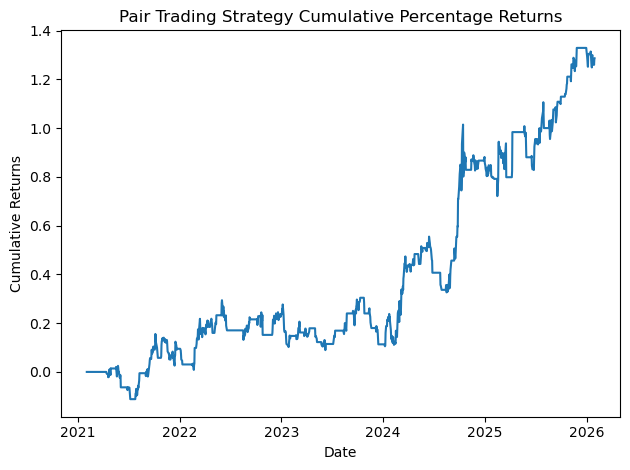

In [118]:
# Calculate the price ratio between the two stocks
price_ratio = stock1_data / stock2_data

# Calculate z-score of the spread based on a rolling 3-month window
spread_mean = spread.rolling(window=window).mean()
spread_std = spread.rolling(window=window).std()
z_score = (spread - spread_mean) / spread_std

current_capital = initial_capital

# Generate signals
signals = np.where(z_score > entry_threshold, -1, np.where(z_score < -entry_threshold, 1, 0))

# Backtest the pair trading strategy
position = 0
transaction_cost = 0
pr = price_ratio.iloc[0]
pct_returns = []
completed_trades = 0
margin_call_count = 0
t = 0
a , b = 0, 0
current_trade_pl = 0
multiple = 0
stop_loss_count = 0
cooldown_period = 0

# Trade logging
trades_log = []
entry_info = None

for i in range(1, len(signals)):
    old_position = position

    # Compute daily realized P/L based on previous position
    if old_position == 1:
        r = multiple *(a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]) - b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]))
    elif old_position == -1:
        r = multiple * (b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]) - a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]))
    else:
        r = 0

    # Daily financing costs (borrow interest + short borrow fee) while position is open
    financing_cost = 0.0
    if position != 0 and multiple > 0:
        # Current prices
        p1 = stock1_data.iloc[i]
        p2 = stock2_data.iloc[i]
        # Notional of short leg depends on position sign
        if position == 1:
            notional_short = multiple * b * p2
        else:  # position == -1
            notional_short = multiple * a * p1
        notional_short = max(0.0, notional_short)

        # Borrowed cash amount = market notional of the position - equity used at entry
        current_notional = multiple * (abs(a * p1) + abs(b * p2))
        borrowed_cash = max(0.0, current_notional - current_capital - r)

        # Daily interest/fees (assuming 252 trading days)
        daily_borrow_interest = borrowed_cash * (borrowing_pct_cost_annual / 252)
        daily_short_fee = notional_short * (short_sell_pct_cost_annual / 252)

        financing_cost = -(daily_borrow_interest + daily_short_fee)

    # Apply P/L and financing costs
    current_trade_pl += r + financing_cost
    # Include transaction_cost (entry commission) on the day it was set; financing_cost applied daily
    daily_total = r + financing_cost + transaction_cost
    pct_returns.append(daily_total / current_capital if current_capital != 0 else 0)
    current_capital += daily_total

    # Reset transaction cost after it's applied
    transaction_cost = 0

    if cooldown_period > 0:
        cooldown_period -= 1
        continue

    # Entry signals
    if signals[i] == 1 and position == 0:
        position = 1
        pr = price_ratio.iloc[i]
    elif signals[i] == -1 and position == 0:
        position = -1
        pr = price_ratio.iloc[i]

    # Exit / stop loss
    elif current_trade_pl / current_capital <= -stop_loss_pct or (signals[i] == 0 and abs(z_score.iloc[i]) < exit_threshold and position != 0):
        if current_trade_pl / current_capital <= -stop_loss_pct:
            cooldown_period = 10
            stop_loss_count += 1
        # log exit if trade was open
        if entry_info is not None:
            entry_info.update({
                'exit_index': i,
                'exit_date': stock1_data.index[i],
                'pnl': current_trade_pl,
            })
            trades_log.append(entry_info)
        # Exit the position
        position = 0
        completed_trades += 1
        current_trade_pl = 0
        multiple = 0
        entry_info = None

    # On entry, compute integer multiple using leverage and record entry info
    if old_position == 0 and position != 0:
        if pr < 1:
            a = round(1 / pr)
            b = 1
        else:
            a = 1
            b = round(pr)
        t = i
        cost_per_unit = (a * stock1_data.iloc[i] + b * stock2_data.iloc[i])
        # Allow notional up to current_capital * leverage
        if cost_per_unit > 0:
            multiple = int((current_capital * leverage) // cost_per_unit)
        else:
            multiple = 0
        # commission/entry cost
        transaction_cost = - multiple * cost_per_unit * 0.1105/100

        # record entry
        entry_info = {
            'entry_index': i,
            'entry_date': stock1_data.index[i],
            'position': position,
            'a': a,
            'b': b,
            'multiple': multiple,
            'entry_capital': current_capital,
            'capital_used': multiple * cost_per_unit,
            'entry_cost': transaction_cost
        }

    # Margin check while position is open: compute gross position market value
    if position != 0 and multiple > 0:
        pos_market_value = multiple * (abs(a * stock1_data.iloc[i]) + abs(b * stock2_data.iloc[i]))
        # Avoid division by zero
        if pos_market_value > 0:
            margin_ratio = current_capital / pos_market_value
        else:
            margin_ratio = np.inf
        # Trigger margin call (forced liquidation) if maintenance margin breached
        if margin_ratio < maintenance_margin_pct:
            print(f"Margin call triggered at index {i}, date {stock1_data.index[i]}, margin_ratio={margin_ratio:.4f}, capital={current_capital:.2f}")
            # log exit due to margin call
            if entry_info is not None:
                entry_info.update({
                    'exit_index': i,
                    'exit_date': stock1_data.index[i],
                    'pnl': current_trade_pl,
                    'exit_reason': 'margin_call'
                })
                trades_log.append(entry_info)
            # force exit: realize liquidation (already included in r), then reset position
            position = 0
            completed_trades += 1
            margin_call_count += 1
            current_trade_pl = 0
            multiple = 0
            entry_info = None

# End loop
print(f"Completed trades: {completed_trades}")
print(f"Stop losses triggered: {stop_loss_count}")
print(f"Margin calls: {margin_call_count}")
print(f"Total return: {(current_capital - initial_capital) / initial_capital:.2%}")
print(f"Annualized return: {((current_capital / initial_capital) ** (252 / len(pct_returns)) - 1) * 100:.2f}%")

# Calculate cumulative returns
cumulative_pct_returns = np.cumprod(1 + np.array(pct_returns)) - 1 if len(pct_returns) > 0 else np.array([])
fig, ax = plt.subplots(1, 1)
ax.plot(stock1_data.index[1:1+len(cumulative_pct_returns)], cumulative_pct_returns)
ax.set_title('Pair Trading Strategy Cumulative Percentage Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# --- Sharpe ratio calculation (annualized) ---
daily_returns = np.array(pct_returns)
mean_daily = np.nanmean(daily_returns) if len(daily_returns) > 0 else 0.0
std_daily = np.nanstd(daily_returns) if len(daily_returns) > 0 else 0.0
annual_factor = 252
if std_daily == 0 or np.isnan(std_daily):
    sharpe_ratio = np.nan
else:
    sharpe_ratio = (mean_daily / std_daily) * np.sqrt(annual_factor)
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.4f}")

plt.tight_layout()
plt.show()
# Implement risk management and further refine the strategy as needed

In [119]:
# Save/print trade log
trades_df = pd.DataFrame(trades_log)
if not trades_df.empty:
    display(trades_df)
    # optional: save to CSV
    # trades_df.to_csv('trade_log.csv', index=False)

,entry_index,entry_date,position,a,b,multiple,entry_capital,capital_used,entry_cost,exit_index,exit_date,pnl
0,46,2021-04-13,1,13,1,3,100000.000000,166862.380028,-184.382930,59,2021-04-30,1595.434785
1,70,2021-05-17,1,13,1,3,101411.051855,185093.439102,-204.528250,83,2021-06-04,-7528.471112
2,97,2021-06-25,1,15,1,2,93678.052493,134313.667297,-148.416602,100,2021-06-30,185.720325
3,101,2021-07-02,-1,14,1,3,93715.356216,180971.097565,-199.973063,105,2021-07-08,-4684.087583
4,117,2021-07-26,-1,13,1,3,88831.295571,167036.199760,-184.575001,128,2021-08-10,10829.066062
5,144,2021-09-01,1,17,1,3,99475.786632,177932.824516,-196.615771,172,2021-10-15,6489.647385
6,179,2021-10-26,1,17,1,3,105768.818246,172641.512489,-190.768871,221,2021-12-23,3907.727318
7,227,2022-01-03,-1,15,1,3,109485.776692,164973.964691,-182.296231,233,2022-01-11,-6241.580317
8,255,2022-02-15,1,14,1,3,103061.900144,170746.901321,-188.675326,262,2022-02-24,6954.931491
9,265,2022-03-01,1,13,1,3,109828.156309,172219.366264,-190.302400,305,2022-04-29,6353.066837
